Data Loading and Preprocessing
Imports necessary libraries like cv2, numpy, and train_test_split for image processing and dataset splitting.
Defines dataset paths for X-ray and CT scan images.
Implements load_images_from_folder(folder) function:
Reads images from "COVID" and "Non-COVID" subfolders.
Converts them to grayscale and resizes them to 224x224.
Labels images as 1 for "COVID" and 0 for "Non-COVID".
Loads images from both X-ray and CT datasets.
Converts images to NumPy arrays, normalizing pixel values to [0,1] and reshaping them for CNN input.
Splits datasets into training (80%), validation (10%), and testing (10%).
Prints dataset statistics.

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Set image size for processing
IMG_SIZE = (224, 224)

# Define dataset paths (ensure these are correct for your setup)
X_RAY_PATH = '/kaggle/input/covid-19-xray-and-ct-scan-image-dataset/COVID-19 Dataset/X-ray/'
CT_PATH = '/kaggle/input/covid-19-xray-and-ct-scan-image-dataset/COVID-19 Dataset/CT/'

def load_images_from_folder(folder):
    """
    Loads images from a specified folder, assuming the presence of 'COVID' and 'Non-COVID' subfolders.
    - Converts images to grayscale.
    - Resizes them to 224x224.
    - Assigns labels: 1 for 'COVID' and 0 for 'Non-COVID'.

    Args:
        folder (str): Path to the main directory containing 'COVID' and 'Non-COVID' subfolders.

    Returns:
        tuple: (list of processed images, list of corresponding labels)
    """
    images, labels = [], []

    # Process both 'COVID' and 'Non-COVID' categories
    for category in ["COVID", "Non-COVID"]:
        class_label = 1 if category == "COVID" else 0  # 1 for COVID, 0 for Non-COVID
        category_path = os.path.join(folder, category)

        # Check if the directory exists
        if not os.path.exists(category_path):
            print(f"Warning: Folder not found - {category_path}")
            continue

        # Iterate through images in the folder
        for filename in os.listdir(category_path):
            img_path = os.path.join(category_path, filename)

            # Read image in grayscale
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, IMG_SIZE)  # Resize to 224x224
                images.append(img)
                labels.append(class_label)

    return images, labels

# Load images and labels from both X-ray and CT datasets
xray_images, xray_labels = load_images_from_folder(X_RAY_PATH)
ct_images, ct_labels = load_images_from_folder(CT_PATH)

# Print dataset summary
print(f"Total X-ray images loaded: {len(xray_images)}")
print(f"Total CT scan images loaded: {len(ct_images)}")

# Convert images to NumPy arrays and normalize pixel values to the range [0,1]
xray_images = np.array(xray_images, dtype=np.float32) / 255.0
ct_images = np.array(ct_images, dtype=np.float32) / 255.0

# Reshape to match CNN input format (adding channel dimension)
xray_images = xray_images.reshape(-1, 224, 224, 1)  
ct_images = ct_images.reshape(-1, 224, 224, 1)

# Convert labels to NumPy arrays
xray_labels = np.array(xray_labels, dtype=np.int32)
ct_labels = np.array(ct_labels, dtype=np.int32)

# Ensure both datasets have the same number of samples (trim the larger one)
min_size = min(len(xray_images), len(ct_images))
xray_images, xray_labels = xray_images[:min_size], xray_labels[:min_size]
ct_images, ct_labels = ct_images[:min_size], ct_labels[:min_size]

# Split datasets into training, validation, and test sets (80% train, 10% validation, 10% test)
X_xray_train, X_xray_test, y_xray_train, y_xray_test = train_test_split(xray_images, xray_labels, test_size=0.2, random_state=42)
X_xray_train, X_xray_val, y_xray_train, y_xray_val = train_test_split(X_xray_train, y_xray_train, test_size=0.1, random_state=42)

X_ct_train, X_ct_test, y_ct_train, y_ct_test = train_test_split(ct_images, ct_labels, test_size=0.2, random_state=42)
X_ct_train, X_ct_val, y_ct_train, y_ct_val = train_test_split(X_ct_train, y_ct_train, test_size=0.1, random_state=42)

# Display the final dataset shapes
print("\nDataset split summary:")
print(f"Training Set   -> X-ray: {X_xray_train.shape}, CT: {X_ct_train.shape}")
print(f"Validation Set -> X-ray: {X_xray_val.shape}, CT: {X_ct_val.shape}")
print(f"Test Set       -> X-ray: {X_xray_test.shape}, CT: {X_ct_test.shape}")


X-ray CNN Model Definition
Imports TensorFlow Keras layers for building a Convolutional Neural Network (CNN).
Defines build_xray_cnn() function:
Creates a CNN for processing X-ray images.
Uses Conv2D layers with ReLU activation.
Adds MaxPooling2D for downsampling.
Applies BatchNormalization for stable training.
Uses Flatten() to convert features into a dense layer.
Implements a Dense(128, activation='relu') layer with Dropout(0.5) to reduce overfitting.
Builds and summarizes the X-ray model.


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
    BatchNormalization, Input
)

def build_xray_cnn(input_shape=(224, 224, 1)):
    """Creates a simple CNN model for processing X-ray images."""
    
    inputs = Input(shape=input_shape)

    # First set of convolutional layers
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)
    norm1 = BatchNormalization()(pool1)

    # Second set of convolutional layers
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(norm1)
    pool2 = MaxPooling2D((2, 2))(conv2)
    norm2 = BatchNormalization()(pool2)

    # Fully connected layers
    flat = Flatten()(norm2)
    dense1 = Dense(128, activation='relu')(flat)
    dropout1 = Dropout(0.5)(dense1)

    # Construct the model
    model = Model(inputs=inputs, outputs=dropout1, name='Xray_CNN')

    return model

# Initialize and summarize the X-ray CNN model
xray_model = build_xray_cnn()
xray_model.summary()


Model: "Xray_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,709,440 (98.07 MB)

 Trainable params: 25,709,248 (98.07 MB)

 Non-trainable params: 192 (768.00 B)

**CT Scan CNN Model Definition**
Similar to the X-ray model, but designed for CT scan images.
Defines build_ct_cnn() function:
Contains convolutional, pooling, normalization, and fully connected layers.
Uses the same architecture as build_xray_cnn(), ensuring consistency in feature extraction.
Builds and summarizes the CT scan model.

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
    BatchNormalization, Input
)

def build_ct_cnn(input_shape=(224, 224, 1)):
    """Creates a CNN model for processing CT scan images."""
    
    inputs = Input(shape=input_shape)

    # First convolutional block
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)
    norm1 = BatchNormalization()(pool1)

    # Second convolutional block
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(norm1)
    pool2 = MaxPooling2D((2, 2))(conv2)
    norm2 = BatchNormalization()(pool2)

    # Fully connected layers
    flat = Flatten()(norm2)
    dense1 = Dense(128, activation='relu')(flat)
    dropout1 = Dropout(0.5)(dense1)

    # Construct the model
    model = Model(inputs=inputs, outputs=dropout1, name='CT_CNN')

    return model

# Initialize and summarize the CT scan CNN model
ct_model = build_ct_cnn()
ct_model.summary()


Model: "CT_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 224, 224, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,709,440 (98.07 MB)

 Trainable params: 25,709,248 (98.07 MB)

 Non-trainable params: 192 (768.00 B)

In [4]:
from tensorflow.keras.layers import Concatenate, Input
from tensorflow.keras.models import Model

# Define input shapes for X-ray and CT images
input_xray = Input(shape=(224, 224, 1), name="Xray_Input")
input_ct = Input(shape=(224, 224, 1), name="CT_Input")

# Extract features using the pre-built CNN models
xray_features = build_xray_cnn()(input_xray)
ct_features = build_ct_cnn()(input_ct)

# Fuse features by concatenation
fused_features = Concatenate(name="Feature_Fusion")([xray_features, ct_features])

# Construct the fusion model
fusion_model = Model(
    inputs=[input_xray, input_ct],
    outputs=fused_features,
    name="Feature_Fusion_Model"
)

# Display the model architecture
fusion_model.summary()


Model: "Feature_Fusion_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Xray_Input (InputLayer)   │ (None, 224, 224, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ CT_Input (InputLayer)     │ (None, 224, 224, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Xray_CNN (Functional)     │ (None, 128)            │     25,709,440 │ Xray_Input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ CT_CNN (Functional)       │ (None, 128)            │     25,709,440 │ CT_Input[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Feature_Fusion            │ (None, 256)            │              0 │ Xray_CNN[0][0],        │
│ (Concatenate)             │                        │                │ CT_CNN[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 51,418,880 (196.15 MB)

 Trainable params: 51,418,496 (196.15 MB)

 Non-trainable params: 384 (1.50 KB)

In [5]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model

# Fully Connected Network (FCN) for classification
x = Dense(256, activation='relu', name="FC_Layer1")(fused_features)
x = Dropout(0.5, name="Dropout1")(x)
x = Dense(128, activation='relu', name="FC_Layer2")(x)
x = Dropout(0.5, name="Dropout2")(x)

# Output layer for binary classification (COVID / Non-COVID)
output = Dense(1, activation='sigmoid', name="Output_Layer")(x)

# Build the final classification model
final_model = Model(
    inputs=[input_xray, input_ct],
    outputs=output,
    name="COVID_Classification_Model"
)

# Compile the model
final_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display the model architecture
final_model.summary()


Model: "COVID_Classification_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Xray_Input (InputLayer)   │ (None, 224, 224, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ CT_Input (InputLayer)     │ (None, 224, 224, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Xray_CNN (Functional)     │ (None, 128)            │     25,709,440 │ Xray_Input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ CT_CNN (Functional)       │ (None, 128)            │     25,709,440 │ CT_Input[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Feature_Fusion            │ (None, 256)            │              0 │ Xray_CNN[0][0],        │
│ (Concatenate)             │                        │                │ CT_CNN[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ FC_Layer1 (Dense)         │ (None, 256)            │         65,792 │ Feature_Fusion[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dropout1 (Dropout)        │ (None, 256)            │              0 │ FC_Layer1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ FC_Layer2 (Dense)         │ (None, 128)            │         32,896 │ Dropout1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dropout2 (Dropout)        │ (None, 128)            │              0 │ FC_Layer2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Output_Layer (Dense)      │ (None, 1)              │            129 │ Dropout2[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 51,517,697 (196.52 MB)

 Trainable params: 51,517,313 (196.52 MB)

 Non-trainable params: 384 (1.50 KB)

**Model Training with Early Stopping**
This portion trains the final classification model while using Early Stopping to prevent overfitting.

1. Early Stopping Setup
Uses EarlyStopping from tensorflow.keras.callbacks.
Monitors val_loss (Validation Loss) to check when the model stops improving.
Patience = 5, meaning if validation loss doesn't improve for 5 consecutive epochs, training stops.
Restores best weights from the epoch with the lowest validation loss.
2. Model Training (final_model.fit())
Trains the model using both X-ray and CT scan images.
x=[X_xray_train, X_ct_train]: Inputs are both X-ray and CT scan images.
y=y_xray_train: Assumes X-ray labels are also valid for CT scans (paired dataset).
Validation Set: ([X_xray_val, X_ct_val], y_xray_val) helps monitor performance on unseen data.
Epochs = 30: The model can train for up to 30 epochs (but may stop early due to Early Stopping).
Batch Size = 16: The model updates weights after processing 16 samples at a time.
callbacks=[early_stopping]: Ensures early stopping is applied.
verbose=1: Prints training progress.

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

# Define Early Stopping to monitor validation loss and avoid overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',     # Watch validation loss
    patience=5,             # Stop training after 5 epochs of no improvement
    restore_best_weights=True  # Restore model weights from the best epoch
)

# Train the final classification model
history = final_model.fit(
    x=[X_xray_train, X_ct_train],   # Input images (X-ray and CT)
    y=y_xray_train,                 # Target labels (Assuming paired X-ray & CT labels)
    validation_data=([X_xray_val, X_ct_val], y_xray_val),  # Validation set
    epochs=30,       # Maximum number of epochs
    batch_size=16,   # Batch size for training
    callbacks=[early_stopping],  # Use early stopping callback
    verbose=1        # Print training progress
)


Epoch 1/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 36s 68ms/step - accuracy: 0.5903 - loss: 24.6430 - val_accuracy: 0.4899 - val_loss: 7.4695
Epoch 2/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.7003 - loss: 2.8496 - val_accuracy: 0.8465 - val_loss: 0.3935
Epoch 3/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.7497 - loss: 0.9271 - val_accuracy: 0.7426 - val_loss: 0.4078
Epoch 4/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.7739 - loss: 0.5760 - val_accuracy: 0.8217 - val_loss: 0.3728
Epoch 5/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.8089 - loss: 0.5069 - val_accuracy: 0.8884 - val_loss: 0.3032
Epoch 6/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.8360 - loss: 0.4272 - val_accuracy: 0.8760 - val_loss: 0.3444
Epoch 7/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.8508 - loss: 0.3634 - val_accuracy: 0.9039 - val_loss: 0.2714
Epoch 8/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.8598 - loss: 0.3613 -

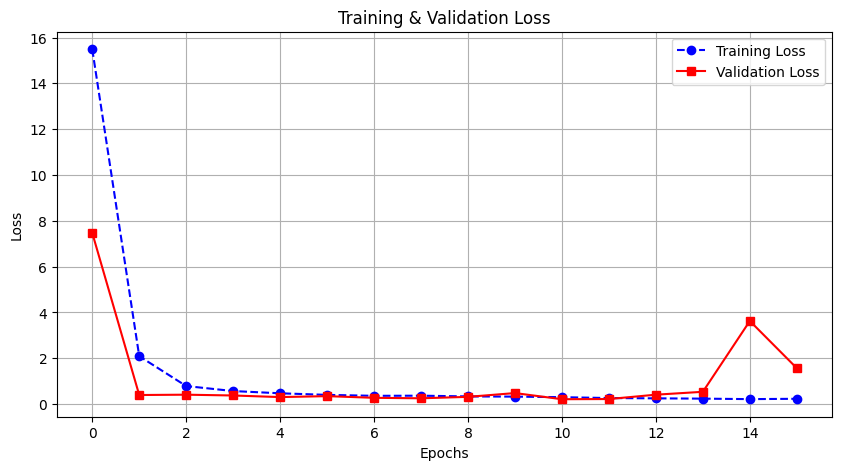

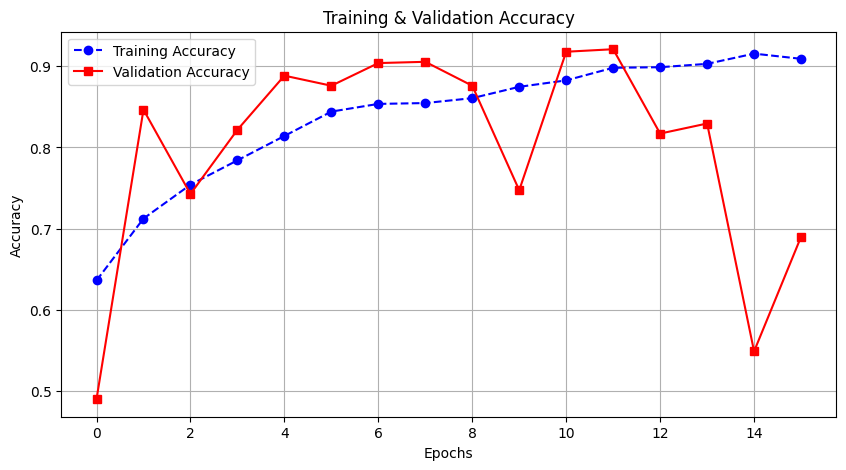

In [7]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_training_history(history):
    """Plots the training and validation loss & accuracy curves."""
    
    # Plot Loss Curves
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue', linestyle='--', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='-', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Accuracy Curves
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue', linestyle='--', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linestyle='-', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot training results
plot_training_history(history)


In [8]:
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout

# Define a function to create the Fully Connected Network with random initialization
def build_random_fcn(fused_features):
    """
    Builds a Fully Connected Network (FCN) using randomly initialized weights.

    Args:
        fused_features (Tensor): Output of the feature fusion layer.

    Returns:
        Model: The final classification model with randomly initialized embeddings.
    """
    x = Dense(256, activation='relu', kernel_initializer=RandomNormal(stddev=0.01))(fused_features)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_initializer=RandomNormal(stddev=0.01))(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)  # Binary classification output

    return output

# Build the model
output_random = build_random_fcn(fused_features)
model_random = Model(inputs=[input_xray, input_ct], outputs=output_random, name='Random_Embedding_Model')

# Compile the model
model_random.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model_random.summary()


Model: "Random_Embedding_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Xray_Input (InputLayer)   │ (None, 224, 224, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ CT_Input (InputLayer)     │ (None, 224, 224, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Xray_CNN (Functional)     │ (None, 128)            │     25,709,440 │ Xray_Input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ CT_CNN (Functional)       │ (None, 128)            │     25,709,440 │ CT_Input[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Feature_Fusion            │ (None, 256)            │              0 │ Xray_CNN[0][0],        │
│ (Concatenate)             │                        │                │ CT_CNN[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 256)            │         65,792 │ Feature_Fusion[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 256)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 128)            │         32,896 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 128)            │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1)              │            129 │ dropout_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 51,517,697 (196.52 MB)

 Trainable params: 51,517,313 (196.52 MB)

 Non-trainable params: 384 (1.50 KB)

In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

def build_pretrained_embedding_model():
    """
    Builds a classification model using a pre-trained VGG16 as the feature extractor.
    The model is frozen to leverage transfer learning without modifying its weights.
    """
    # Load the pre-trained VGG16 model (without top layers)
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze pre-trained weights to retain learned features
    
    # Extract feature representations
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)  # Dropout for regularization
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # Output layer for binary classification
    output = Dense(1, activation='sigmoid')(x)
    
    # Create and return the model
    model = Model(inputs=base_model.input, outputs=output, name='Pretrained_Embedding_Model')
    return model

# Build the model
model_pretrained = build_pretrained_embedding_model()

# Compile the model
model_pretrained.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model_pretrained.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "Pretrained_Embedding_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,170,497 (80.76 MB)

 Trainable params: 6,455,809 (24.63 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
# Convert grayscale X-ray images to 3-channel RGB
X_xray_train_rgb = np.repeat(X_xray_train, 3, axis=-1)
X_xray_val_rgb = np.repeat(X_xray_val, 3, axis=-1)
X_xray_test_rgb = np.repeat(X_xray_test, 3, axis=-1)

# Print shape to verify correctness
print("X-ray Train Shape (RGB):", X_xray_train_rgb.shape)
print("X-ray Val Shape (RGB):", X_xray_val_rgb.shape)
print("X-ray Test Shape (RGB):", X_xray_test_rgb.shape)


X-ray Train Shape (RGB): (5799, 224, 224, 3)
X-ray Val Shape (RGB): (645, 224, 224, 3)
X-ray Test Shape (RGB): (1611, 224, 224, 3)


In [11]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten

def train_model(model, train_data, train_labels, val_data, val_labels, epochs=1, batch_size=16):
    """
    Trains a given model on the provided dataset.
    """
    history = model.fit(
        train_data, train_labels,
        validation_data=(val_data, val_labels),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )
    return history

def build_pretrained_vgg16():
    """
    Builds a classification model using a pre-trained VGG16 as a feature extractor.
    """
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze weights

    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    output = Dense(1, activation='sigmoid')(x)  # Binary classification

    return Model(inputs=base_model.input, outputs=output, name='Pretrained_Embedding_Model')

# Train model with Randomly Initialized Embeddings
history_random = train_model(
    model_random,
    [X_xray_train, X_ct_train], y_xray_train,
    [X_xray_val, X_ct_val], y_xray_val
)

# Clear TensorFlow session before training a new model
tf.keras.backend.clear_session()

# Build and compile the pre-trained VGG16 model
model_pretrained = build_pretrained_vgg16()
model_pretrained.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model with Pre-trained VGG16 embeddings
history_pretrained = train_model(
    model_pretrained,
    X_xray_train_rgb, y_xray_train,
    X_xray_val_rgb, y_xray_val
)

# Evaluate both models on the test set
test_loss_random, test_acc_random = model_random.evaluate([X_xray_test, X_ct_test], y_xray_test)
test_loss_pretrained, test_acc_pretrained = model_pretrained.evaluate(X_xray_test_rgb, y_xray_test)

# Print results
print(f'Random Embeddings - Test Accuracy: {test_acc_random:.4f}')
print(f'Pre-trained Embeddings - Test Accuracy: {test_acc_pretrained:.4f}')


363/363 ━━━━━━━━━━━━━━━━━━━━ 29s 60ms/step - accuracy: 0.8417 - loss: 0.4215 - val_accuracy: 0.8620 - val_loss: 0.3493
363/363 ━━━━━━━━━━━━━━━━━━━━ 53s 114ms/step - accuracy: 0.6776 - loss: 0.8547 - val_accuracy: 0.8202 - val_loss: 0.3995
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8636 - loss: 0.3504
51/51 ━━━━━━━━━━━━━━━━━━━━ 30s 304ms/step - accuracy: 0.8065 - loss: 0.4093
Random Embeddings - Test Accuracy: 0.8560
Pre-trained Embeddings - Test Accuracy: 0.8014


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
Classification Report:
               precision    recall  f1-score   support

   Non-COVID       0.95      0.75      0.84       813
       COVID       0.79      0.96      0.87       798

    accuracy                           0.85      1611
   macro avg       0.87      0.86      0.85      1611
weighted avg       0.87      0.85      0.85      1611



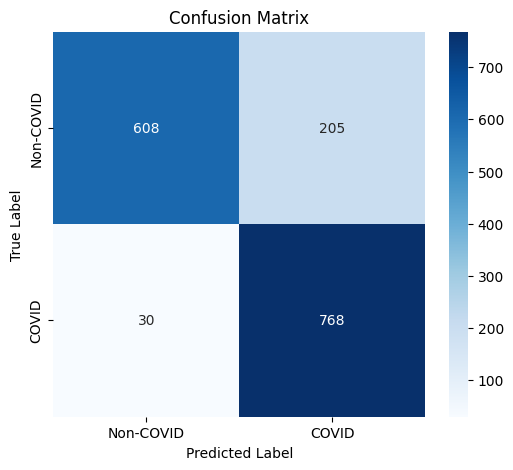

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, test_data, test_labels, threshold=0.5):
    """
    Evaluates the model using classification report and confusion matrix.
    """
    # Make predictions
    y_pred_prob = model.predict(test_data)
    y_pred = (y_pred_prob > threshold).astype(int)  # Convert probabilities to binary labels

    # Generate classification report
    report = classification_report(test_labels, y_pred, target_names=['Non-COVID', 'COVID'])
    print("Classification Report:\n", report)

    # Compute and plot confusion matrix
    plot_confusion_matrix(test_labels, y_pred)

def plot_confusion_matrix(y_true, y_pred):
    """
    Plots the confusion matrix for the given predictions.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-COVID', 'COVID'], yticklabels=['Non-COVID', 'COVID'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate the final model
evaluate_model(final_model, [X_xray_test, X_ct_test], y_xray_test)


In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred_prob = final_model.predict([X_xray_test, X_ct_test])
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary labels

# Compute classification report
report = classification_report(y_xray_test, y_pred, target_names=['Non-COVID', 'COVID'])
print(report)


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
              precision    recall  f1-score   support

   Non-COVID       0.95      0.75      0.84       813
       COVID       0.79      0.96      0.87       798

    accuracy                           0.85      1611
   macro avg       0.87      0.86      0.85      1611
weighted avg       0.87      0.85      0.85      1611



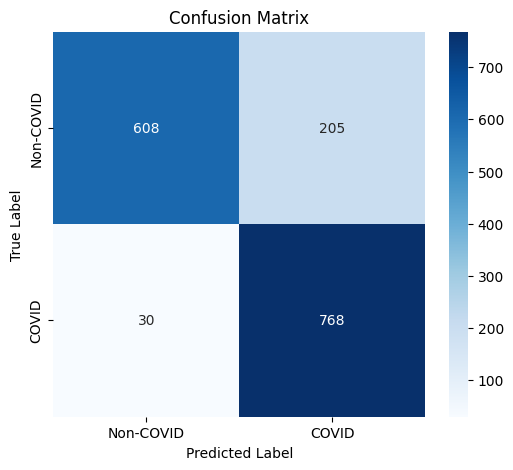

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert predicted probabilities to binary labels (Threshold at 0.5)
y_pred_binary = (y_pred > 0.5).astype(int)

# Compute Confusion Matrix
cm = confusion_matrix(y_xray_test, y_pred_binary)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-COVID', 'COVID'], yticklabels=['Non-COVID', 'COVID'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


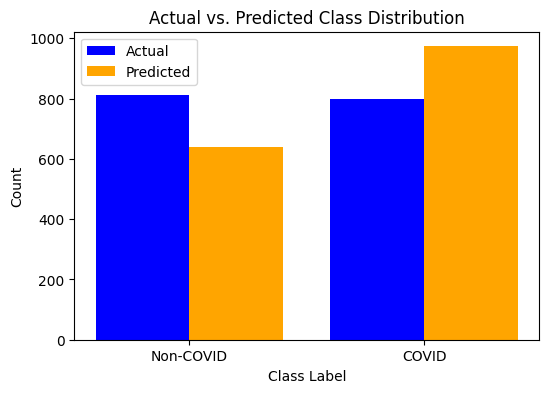

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Convert predictions to binary (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Count occurrences of each class
unique_actual, counts_actual = np.unique(y_xray_test, return_counts=True)
unique_pred, counts_pred = np.unique(y_pred_binary, return_counts=True)

# Ensure both classes (0 and 1) appear even if missing from predictions
actual_counts_dict = {0: 0, 1: 0}
pred_counts_dict = {0: 0, 1: 0}

for cls, count in zip(unique_actual, counts_actual):
    actual_counts_dict[cls] = count

for cls, count in zip(unique_pred, counts_pred):
    pred_counts_dict[cls] = count

# Extract counts again after ensuring both classes exist
actual_counts = [actual_counts_dict[0], actual_counts_dict[1]]
pred_counts = [pred_counts_dict[0], pred_counts_dict[1]]

# Create a bar plot for actual vs predicted counts
plt.figure(figsize=(6, 4))
bar_width = 0.4
x_labels = ['Non-COVID', 'COVID']
x = np.arange(len(x_labels))

plt.bar(x - bar_width/2, actual_counts, width=bar_width, label='Actual', color='blue')
plt.bar(x + bar_width/2, pred_counts, width=bar_width, label='Predicted', color='orange')

plt.xticks(x, x_labels)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Actual vs. Predicted Class Distribution')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


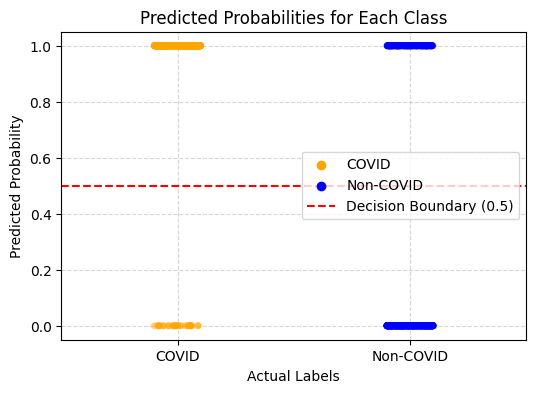

In [17]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert actual labels to categorical for better visualization
class_labels = {0: 'Non-COVID', 1: 'COVID'}
df = pd.DataFrame({
    'Actual': [class_labels[label] for label in y_xray_test],  # Convert 0/1 to class names
    'Predicted Probability': y_pred.flatten()
})

# Plot using Seaborn
plt.figure(figsize=(6, 4))
sns.stripplot(data=df, x='Actual', y='Predicted Probability', jitter=True, alpha=0.5, hue='Actual', palette={'Non-COVID': 'blue', 'COVID': 'orange'})

# Add decision boundary line
plt.axhline(y=0.5, color='r', linestyle='--', label='Decision Boundary (0.5)')

# Improve aesthetics
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Probability')
plt.title('Predicted Probabilities for Each Class')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()
